In [1]:
from streaming import StreamingEnvironment
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

In [2]:
#set alpha value
alpha = 0.5

#set epsilon to a small value
epsilon = .05

discount = .9

env = StreamingEnvironment()  # create an instance of the environemnt 

In [3]:
# setup Q as Q[buffer][throughput(we only use 1-4)][future_throughput(we only use 1-4)][value of action(we only use 1-4)]
Q = np.zeros((11,5,5,5))
for i in range(11):
    
    Q[i] = i
    for j in range(5):
        
        Q[i][j] = j
        for k in range(5):
            
            Q[i][j][k] = k
            for val in range(5):
                Q[i][j][k][val] = 0

In [4]:
episode_reward = []

In [12]:
DEBUG = input("run the episodes with DEBUG? (L,M,H,n) (L - low)(M - medium) (H - high) (n - no)")
eps = input('How many episodes?')
for _ in range(int(eps)):
    
    done = False
    if DEBUG == 'L' or DEBUG =='M' or DEBUG == 'H' or DEBUG =='n':
        print("===============================NEW EPISODE=================================")
    #step = env.reset()
    cumulative_reward = 0
    State = np.array(env.reset().observation, dtype=int)
    observed_states = []
    observed_actions = []
    while not done:       
        # current S
        observed_states.append(np.array(State))
        print("State is: ", State.tolist())

        #choose A from S
        if DEBUG == 'M' or DEBUG == 'H':
            print("the current Q in state S: ", State.tolist(), " Q: ", Q[State[0],State[1],State[2]].flatten())
       # actionset = env.valid_actions(State)
        if env.Last_packet != 0:
            action = 0
            print("waiting on last packet: ", env.Last_action)
        else:
            if np.random.rand() < 1 - epsilon:

                #print("the value of the np.argmax is: ", np.argmax(Q[State[0],State[1],State[2]].flatten()))
                #print("the value of the np.amax is : ", np.amax(Q[State[0],State[1],State[2]].flatten()))
                choices = np.argwhere(Q[State[0],State[1],State[2]].flatten() == np.amax(Q[State[0],State[1],State[2]].flatten()))
                if DEBUG == 'L' or DEBUG =='M' or DEBUG =='H':
                    print("choices are: ", choices.flatten())
                action = np.random.choice(choices.flatten())

            else:
                action = np.random.choice([1,2,3,4])
       
        #if DEBUG =='M' or DEBUG =='H':
        #    print("Executing action:",ACTION[action])
        print("Executing action: ", action)
        observed_actions.append(action)

        #take action A and observe next state S' and reward R
        step = env.step(action)
        state_prime = np.array(step.observation, dtype=int)
        if DEBUG == 'L' or DEBUG =='M' or DEBUG =='H':
            print("S is: ", State.tolist()," executing action: ",action, "and S' is: ",state_prime.tolist())

        reward = step.reward
        cumulative_reward += reward
        
        if DEBUG == 'M' or DEBUG == 'L':
            print("Reward was: ", reward)
        
        if DEBUG == 'H':
            print("** Updating Q values now**")
            print("** Current value of Q for action ,",action, " in this state ", State.tolist(), " is:  ", Q[State[0],State[1],State[2],[action]])
            print("** reward was: ", reward)
            print("** argmax of Q for S' was: ",np.max(Q[state_prime[0],state_prime[1],state_prime[2]]))
            print("** Q for the end of formula was: ", Q[State[0],State[1],State[2],[action]])
            print("** S' is: ",state_prime.tolist())
        
        #update our Q
        Q[State[0],State[1],State[2],[action]] += alpha * (reward + discount*np.max(Q[state_prime[0],state_prime[1],state_prime[2]]) - Q[State[0],State[1],State[2],[action]])
        if DEBUG == 'H':
             print("** After update, the value of Q for action ,", action , " in this state ", State.tolist(), " is:  ", Q[State[0],State[1],State[2],[action]])
        State = state_prime
        
        #looping min(length of observed_states or n) times for the planning stage
        if DEBUG == 'H':
            print("- - Entering the planning stage")
            print("- - length of the observed states list ",len(observed_states))
            print("- - observed_states contains, ", observed_states)
        for n in range(min(len(observed_states),25)):
            
            #pick previously visited state S
            randChoice = np.random.randint(low=0,high=len(observed_states))
            randS = tuple(observed_states[randChoice])
            if  DEBUG == 'H':
                print("- - chose random state :",randS)
            #take action A (a random valid action for the state)
            randA = np.random.choice([1,2,3,4])
            if  DEBUG == 'H':
                print("- - chose a random action",randA)
            
            old_state = list(randS)
            #query the model for S' and R
            next_state, model_reward = env.sample_new_state(old_state,randA)
            if  DEBUG == 'H':
                print("- - model gave sample s' of ", next_state.tolist(), " and reward of ", model_reward)
            #update Q
            if DEBUG == 'H':
                print("- - ** initial value of Q for action ", randA," is ", Q[randS[0],randS[1],randS[2],[randA]], " argmax of Q(S',a) is ",np.max(Q[next_state[0],next_state[1],next_state[2]]) )
            Q[randS[0],randS[1],randS[2],[randA]] += alpha * (model_reward + discount*np.max(Q[next_state[0],next_state[1],next_state[2]]) - Q[randS[0],randS[1],randS[2],[randA]])
            if DEBUG == 'H':
                print("- - ** adjusted value of Q is ",Q[randS[0],randS[1],randS[2],[randA]] )

        #print(State[0])
        #checking for the end of the episode        
        if step.is_last():
            print("Buffer Empty!!")
            observed_states.append(state_prime)
            done = True

        #elif step.reward == 1:
            #print("Maximized throughput usage!!")
            #print("reward so far is:", cumulative_reward)
            
        elif State[0] == [10]:
            print("Finished one buffer! Quitting now")
            observed_states.append(state_prime)
            done = True
            
    #episode finished PRINT THE PATH TAKEN
    if DEBUG == 'L' or DEBUG == 'M' or DEBUG == 'H':
        for i in range(0,len(observed_states)-1):
            #S,A = episode[i]
            print("The path was state ", observed_states[i].tolist()," and action ",observed_actions[i])
            
        print("Final State was ", observed_states[-1].tolist())

    print("episode reward was: ", cumulative_reward)
    episode_reward.append(cumulative_reward)
    

run the episodes with DEBUG? (L,M,H,n) (L - low)(M - medium) (H - high) (n - no)n
How many episodes?100
===============================NEW EPISODE=================================
State is:  [[2], [2], [2]]
Executing action:  3
the chosen action  3 is too large for the available throughput  [2]
Waiting for  [1]  more bytes for this packet
State is:  [[1], [2], [3]]
waiting on last packet:  3
Executing action:  0
The chosen packet  3  was finally downloaded
The buffer is now  [3]
Buffer Empty!!
episode reward was:  -1.0
===============================NEW EPISODE=================================
State is:  [[2], [2], [2]]
Executing action:  2
Action  2  fits within throughput  [2]
Buffer size is now  [3]
State is:  [[3], [2], [2]]
Executing action:  3
the chosen action  3 is too large for the available throughput  [2]
Waiting for  [1]  more bytes for this packet
State is:  [[2], [2], [4]]
waiting on last packet:  3
Executing action:  0
The chosen packet  3  was finally downloaded
The buf

State is:  [[7], [1], [4]]
Executing action:  4
the chosen action  4 is too large for the available throughput  [1]
Waiting for  [3]  more bytes for this packet
State is:  [[6], [4], [4]]
waiting on last packet:  4
Executing action:  0
The chosen packet  4  was finally downloaded
The buffer is now  [9]
State is:  [[9], [4], [2]]
Executing action:  1
Action  1  fits within throughput  [4]
Buffer size is now  [9]
State is:  [[9], [2], [3]]
Executing action:  2
Action  2  fits within throughput  [2]
Buffer size is now  [10]
Finished one buffer! Quitting now
episode reward was:  5.0
===============================NEW EPISODE=================================
State is:  [[2], [2], [4]]
Executing action:  2
Action  2  fits within throughput  [2]
Buffer size is now  [3]
State is:  [[3], [4], [1]]
Executing action:  2
Action  2  fits within throughput  [4]
Buffer size is now  [4]
State is:  [[4], [1], [4]]
Executing action:  1
Action  1  fits within throughput  [1]
Buffer size is now  [4]
State

State is:  [[7], [2], [4]]
Executing action:  4
the chosen action  4 is too large for the available throughput  [2]
Waiting for  [2]  more bytes for this packet
State is:  [[6], [4], [4]]
waiting on last packet:  4
Executing action:  0
The chosen packet  4  was finally downloaded
The buffer is now  [9]
State is:  [[9], [4], [4]]
Executing action:  4
Action  4  fits within throughput  [4]
Finished one buffer! Quitting now
episode reward was:  5.0
===============================NEW EPISODE=================================
State is:  [[2], [2], [1]]
Executing action:  2
Action  2  fits within throughput  [2]
Buffer size is now  [3]
State is:  [[3], [1], [4]]
Executing action:  1
Action  1  fits within throughput  [1]
Buffer size is now  [3]
State is:  [[3], [4], [1]]
Executing action:  2
Action  2  fits within throughput  [4]
Buffer size is now  [4]
State is:  [[4], [1], [4]]
Executing action:  1
Action  1  fits within throughput  [1]
Buffer size is now  [4]
State is:  [[4], [4], [2]]
Exe

State is:  [[9], [2], [3]]
Executing action:  2
Action  2  fits within throughput  [2]
Buffer size is now  [10]
Finished one buffer! Quitting now
episode reward was:  5.0
===============================NEW EPISODE=================================
State is:  [[2], [2], [1]]
Executing action:  2
Action  2  fits within throughput  [2]
Buffer size is now  [3]
State is:  [[3], [1], [4]]
Executing action:  1
Action  1  fits within throughput  [1]
Buffer size is now  [3]
State is:  [[3], [4], [1]]
Executing action:  4
Action  4  fits within throughput  [4]
Buffer size is now  [6]
State is:  [[6], [1], [4]]
Executing action:  0
Action  0  fits within throughput  [1]
Buffer size is now  [5]
State is:  [[5], [4], [1]]
Executing action:  4
Action  4  fits within throughput  [4]
Buffer size is now  [8]
State is:  [[8], [1], [1]]
Executing action:  1
Action  1  fits within throughput  [1]
Buffer size is now  [8]
State is:  [[8], [1], [3]]
Executing action:  1
Action  1  fits within throughput  [1]


Finished one buffer! Quitting now
episode reward was:  4.0
===============================NEW EPISODE=================================
State is:  [[2], [2], [1]]
Executing action:  2
Action  2  fits within throughput  [2]
Buffer size is now  [3]
State is:  [[3], [1], [4]]
Executing action:  1
Action  1  fits within throughput  [1]
Buffer size is now  [3]
State is:  [[3], [4], [3]]
Executing action:  1
Action  1  fits within throughput  [4]
Buffer size is now  [3]
State is:  [[3], [3], [3]]
Executing action:  3
Action  3  fits within throughput  [3]
Buffer size is now  [5]
State is:  [[5], [3], [2]]
Executing action:  3
Action  3  fits within throughput  [3]
Buffer size is now  [7]
State is:  [[7], [2], [4]]
Executing action:  2
Action  2  fits within throughput  [2]
Buffer size is now  [8]
State is:  [[8], [4], [1]]
Executing action:  4
Action  4  fits within throughput  [4]
Finished one buffer! Quitting now
episode reward was:  6.0
===============================NEW EPISODE===========

State is:  [[9], [4], [4]]
Executing action:  4
Action  4  fits within throughput  [4]
Finished one buffer! Quitting now
episode reward was:  7.0
===============================NEW EPISODE=================================
State is:  [[2], [2], [1]]
Executing action:  2
Action  2  fits within throughput  [2]
Buffer size is now  [3]
State is:  [[3], [1], [3]]
Executing action:  1
Action  1  fits within throughput  [1]
Buffer size is now  [3]
State is:  [[3], [3], [1]]
Executing action:  3
Action  3  fits within throughput  [3]
Buffer size is now  [5]
State is:  [[5], [1], [3]]
Executing action:  1
Action  1  fits within throughput  [1]
Buffer size is now  [5]
State is:  [[5], [3], [1]]
Executing action:  3
Action  3  fits within throughput  [3]
Buffer size is now  [7]
State is:  [[7], [1], [1]]
Executing action:  1
Action  1  fits within throughput  [1]
Buffer size is now  [7]
State is:  [[7], [1], [4]]
Executing action:  1
Action  1  fits within throughput  [1]
Buffer size is now  [7]
S

State is:  [[8], [2], [2]]
Executing action:  4
the chosen action  4 is too large for the available throughput  [2]
Waiting for  [2]  more bytes for this packet
State is:  [[7], [2], [3]]
waiting on last packet:  4
Executing action:  0
The chosen packet  4  was finally downloaded
The buffer is now  [10]
Finished one buffer! Quitting now
episode reward was:  4.0
===============================NEW EPISODE=================================
State is:  [[2], [2], [2]]
Executing action:  2
Action  2  fits within throughput  [2]
Buffer size is now  [3]
State is:  [[3], [2], [2]]
Executing action:  2
Action  2  fits within throughput  [2]
Buffer size is now  [4]
State is:  [[4], [2], [2]]
Executing action:  2
Action  2  fits within throughput  [2]
Buffer size is now  [5]
State is:  [[5], [2], [2]]
Executing action:  2
Action  2  fits within throughput  [2]
Buffer size is now  [6]
State is:  [[6], [2], [1]]
Executing action:  4
the chosen action  4 is too large for the available throughput  [2]


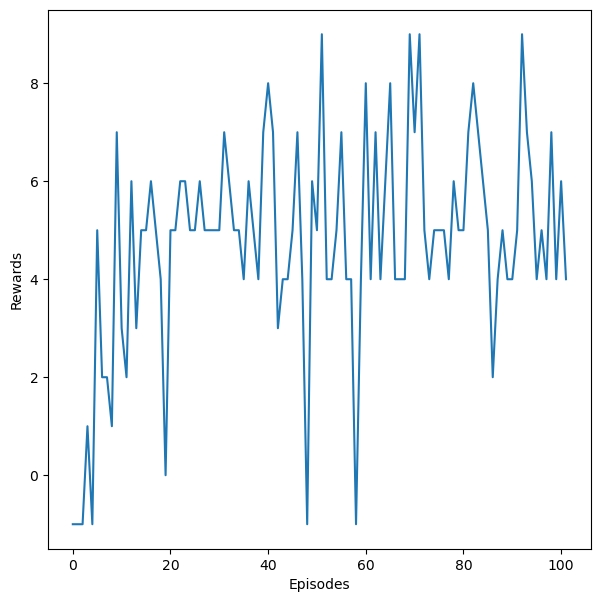

In [13]:
plt.figure(figsize=(7,7))
plt.plot(episode_reward)
plt.ylabel("Rewards")
plt.xlabel("Episodes")
plt.show()

[2, 4, 3, 3, 3]


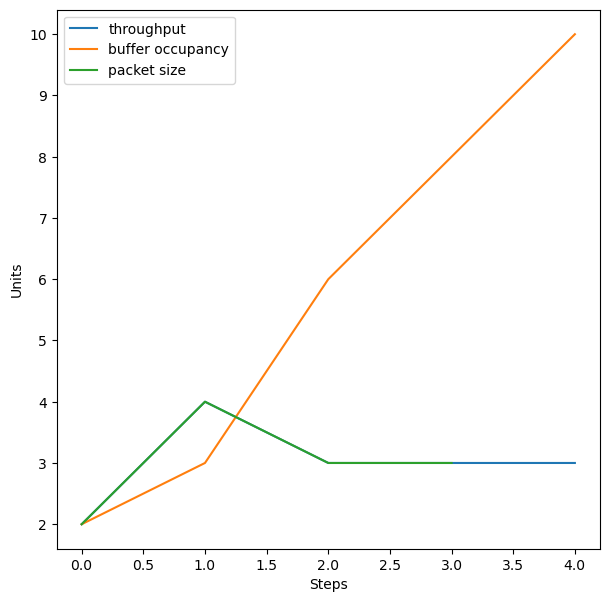

In [14]:
throughput_list = []
buffer_list = []
for i in range(len(observed_states)):
    #print(observed_states[i][1])
    throughput_list.append(int(observed_states[i][1]))
    buffer_list.append(int(observed_states[i][0]))
print(throughput_list)
plt.figure(figsize=(7,7))
plt.plot(throughput_list, label='throughput')
plt.plot(buffer_list, label='buffer occupancy')
plt.plot(observed_actions, label='packet size')
plt.xlabel("Steps")
plt.ylabel("Units")
plt.legend()
plt.show()

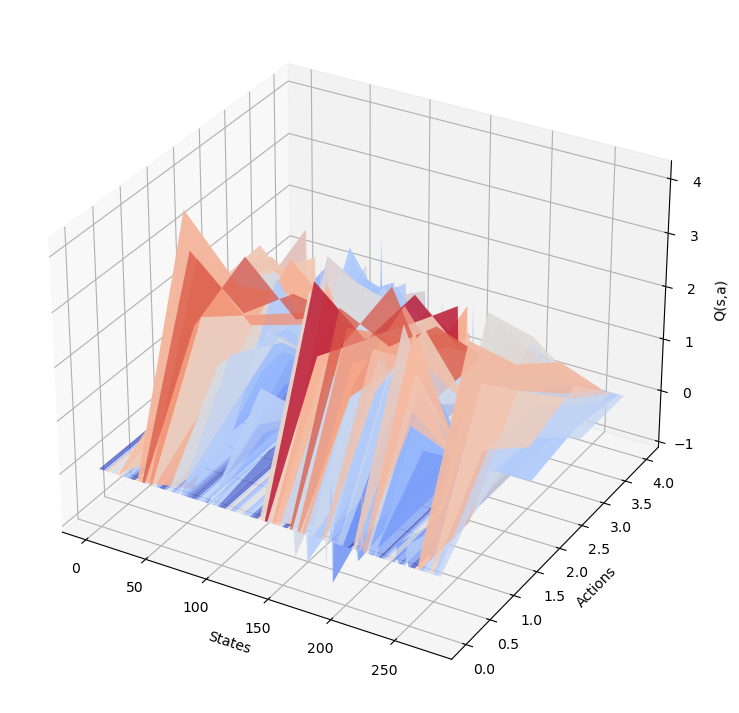

In [17]:
z = np.ravel(Q)

fig = plt.figure(figsize=(10,9))
ax = plt.axes(projection="3d")
_states = []
for a in range(275):
    _states.append(a)
    
#x = state_array
#print(state_array)
x = _states
y = [0,1,2,3,4]
X, Y = np.meshgrid(x,y)
#_z = np.array(z)
_z = z.reshape((5,275))

#print(Q[1])

ax.plot_surface(X,Y,_z,cmap=cm.coolwarm, antialiased=True, alpha=0.75, rstride=10, cstride=2)
plt.xlabel('States')
plt.ylabel('Actions')
ax.set_zlabel('Q(s,a)')
plt.show()

In [6]:
#print(observed_states)
#print(observed_states[0])
#print(observed_states[0][1])
#print(observed_states[1][1])

In [8]:
#print(Q[1][1][1]) # this is how we get the actions for a state
#state_array = []
#for i in range(11):
#    for j in range(5):
#        for k in range(5):
#            #print(i,j,k)
#            state_array.append((i,j,k))
            
#print(len(state_array))
#print(state_array[274])
#print(Q[state_array[274]])
#print(Q[10,4,4])

#z = np.ravel(Q) # this contains all of the Q(s,a) for each S and A
#print(z.ndim)


# x is going to be our state array
# y is going to be our action list (0-4)
# z is going to be a function of Q(state_array[i], action[j])

[0. 0. 0. 0. 0.]
275
(10, 4, 4)
[0.         0.58204911 1.36060412 3.47630286 0.        ]
[0.         0.58204911 1.36060412 3.47630286 0.        ]
1
